# About

- `Main Author:` E. Miles Stoudenmire
- `Source:` [ArXiv](https://arxiv.org/abs/1801.00315)
- `Publish Date:` 31-12-2017
- `Reviewed Date:` 07-06-2021

## Citation

```latex
@article{stoudenmire2018learning,
  title={Learning relevant features of data with multi-scale tensor networks},
  author={Stoudenmire, E Miles},
  journal={Quantum Science and Technology},
  volume={3},
  number={3},
  pages={034003},
  year={2018},
  publisher={IOP Publishing}
}
```

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import cv2

In [4]:
from typing import Tuple, Optional, Iterable, Callable

In [5]:
import os
import itertools

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

# Utilities

## Bitwise operations to determine powers of two

The below code is needed as the paper assumes the tree contains a number of nodes that is some power of two.

In [7]:
def is_power_of_two(n: int) -> bool:
    """
    Check if a given number is a power of two.
    """
    return (n & (n-1) == 0) and n != 0

def power_of_two(n: int) -> Tuple[int, int]:
    """
    Given a number, returns it's previous 
    and next of keen which are powers of two.
    """
    if is_power_of_two(n):
        return n, n
    count = 0    
    while n != 0:
        n >>= 1
        count += 1
    prec = 1 << (count-1)
    succ = 1 << count
    return prec, succ

quickly checking...

In [8]:
is_power_of_two(13), is_power_of_two(256), power_of_two(196)

(False, True, (128, 256))

## The sliding window iterator

In [65]:
def sliding_window(xs: np.ndarray,
                   size: int, 
                   step: Optional[int]=1) -> np.ndarray:
    """
    Sliding window iterator

    Input:
    ------
    xs:             Iterable.
    size:           Window size.
    step:           Step size.
    complement:     Whether to return a complement.
    
    Output:
    -------
    Iterable
    """
    N = xs.size  # we assume that xs is 1D
    chunks = int((N-size)/step + 1)
    result = [xs[i*step:i*step+size] for i in range(chunks)]
    return np.stack(result)

quickly checking...

In [69]:
window_iterator = sliding_window(np.arange(10), size=3, step=2)
print(*window_iterator)

[0 1 2] [2 3 4] [4 5 6] [6 7 8]


## Some linear algebra stuff

In [11]:
def ishermitian(a: np.ndarray, rtol=1e-06, atol=1e-08) -> bool:
    """Check if the matrix is Hermitian"""
    return np.allclose(a, a.conj().T, rtol=rtol, atol=atol)

In [12]:
def ispsd(a: np.ndarray) -> bool:
    """Check if a matrix is positive definite."""
    return np.all(np.linalg.eigvals(a) > 0)

# Loading MNIST dataset

In [13]:
def load_mnist(data_path: str) -> np.ndarray:
    num_labels = 10
    img_size = 28

    # data files
    train_data_path = os.path.join(data_path, 'mnist_train.csv')
    test_data_path = os.path.join(data_path, 'mnist_test.csv')

    # loading data
    train_data = np.loadtxt(train_data_path, delimiter=',')
    test_data = np.loadtxt(test_data_path, delimiter=',')

    # TLDR; scaling to [0.01, 0.99]; we want to avoid zeros and ones
    # Longer answer: https://arxiv.org/pdf/1512.00567.pdf
    frac = 0.99 / 255

    # extracting data and labels
    train_images = np.asfarray(train_data[:, 1:]) * frac + 0.01
    train_labels = np.asfarray(train_data[:, :1])

    test_images = np.asfarray(test_data[:, 1:]) * frac + 0.01
    test_labels = np.asfarray(test_data[:, :1])

    # transform labels into one hot representation
    lr = np.arange(num_labels)
    train_labels_one_hot = (lr==train_labels).astype(float)
    test_labels_one_hot = (lr==test_labels).astype(float)

    # we don't want zeroes and ones in the labels either
    train_labels_one_hot[train_labels_one_hot==0] = 0.01
    train_labels_one_hot[train_labels_one_hot==1] = 0.99
    test_labels_one_hot[test_labels_one_hot==0] = 0.01
    test_labels_one_hot[test_labels_one_hot==1] = 0.99

    return {
        'train': {
            'images': train_images,
            'labels': train_labels_one_hot
        },
        'test': {
            'images': test_images,
            'labels': test_labels_one_hot
        }
    }

In [14]:
data = load_mnist('../data/mnist')

Quickly checking that data is loaded correctly

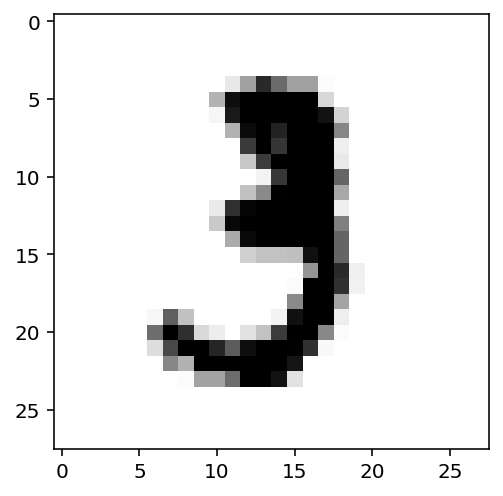

In [15]:
j = 10   # a particularr image index
img_vec = data['train']['images'][j]
size = np.sqrt(img_vec.size).astype(int)
img = img_vec.reshape(size, size)

plt.imshow(img, cmap="Greys")
plt.show()

# Process images

We need to rescale image so the size of eacch image is a power of $2$. This is required for the algorithm to work. First, we determine the nearest powers of $2$ given the size of each image.

In [16]:
j = 10   # a particularr image index
img_vec = data['train']['images'][j]
size_ = np.sqrt(img_vec.size).astype(int)
size, _ = power_of_two(size_)   # returns nearest powers of 2

print(f'The suggested new size is: {size}.')

The suggested new size is: 16.


Now, we downscale each image to this new size.

In [17]:
def resize(image_vec: np.ndarray, shape: Tuple[int,int]) -> np.ndarray:
    orig_size = np.sqrt(img_vec.size).astype(int)
    image = image_vec.reshape(orig_size, orig_size)
    image = cv2.resize(image, shape, interpolation=cv2.INTER_CUBIC)
    return image.reshape(-1,1)
    
new_shape = (8,8)  # I actually downscale even more to save exec time

train_images = np.squeeze(np.apply_along_axis(lambda x: resize(x, new_shape), axis=1, arr=data['train']['images']))
test_images = np.squeeze(np.apply_along_axis(lambda x: resize(x, new_shape), axis=1, arr=data['test']['images']))

In [18]:
train_images.shape

(60000, 64)

Checking if data is scaled properly by plotting random digits...

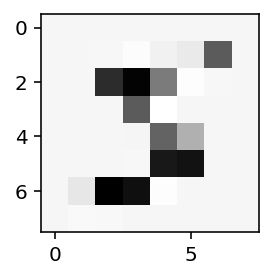

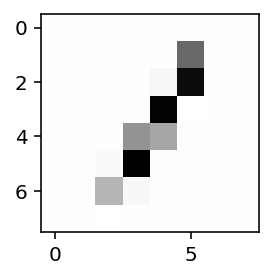

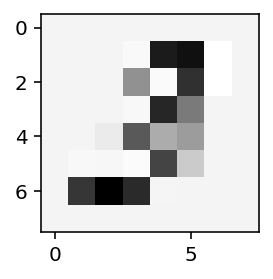

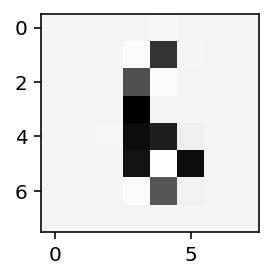

In [19]:
def show_digit(image_vec: np.ndarray) -> None:
    assert image_vec.ndim == 1
    size = np.sqrt(image_vec.size).astype(int)
    plt.rcParams["figure.figsize"] = (2,2)
    plt.imshow(image_vec.reshape(size, size), cmap="Greys")
    plt.show()

digits_idx = (0,23,157,996)    # plot random images
for j in digits_idx:
    show_digit(train_images[j])

# Feature map

The feature map $\Phi(\bf x)$ maps inpunt data vector $\bf x$ from a space of dimension $N$ to a space of dimension $d^N$, i.e. each component of the input vector $x_j$ is mapped into a $d$-dimensional vector. See Eq. 8 in text.

The tensor $\Phi^{s_1 s_2 \cdots s_N}$ is the tensor productof the local feature maps $\Phi^{s_j}(x_j)$ applied to each input $x_j$ along the indices $s_j = 1,2,\cdots,N$. The local feature map is required to have unit norm analogous to the wave function norm, otherwise the tensor networks are not guaranteed to be numerically stable.



In [20]:
FMap = Callable[np.ndarray, np.ndarray] # type alias

def feature_map(xs: Iterable, 
                f: FMap,
                *fs: Iterable[FMap],
                acc: Optional[np.ndarray]=None) -> np.ndarray:
    """
    Feature mapping for a single data sample (image vector).
    Input:
    ------

    Output:
    -------
    An array containing feature values for each vector value.
    The size of the output is features x vector
    """
    vf = np.vectorize(f)
    acc = vf(xs) if acc is None else np.r_[acc, vf(xs)]
    if fs:
        yield from feature_map(xs, *fs, acc=acc)
    else:
        yield acc

def tensorize_dataset(a: np.ndarray, *fs: Iterable[FMap]) -> np.ndarray:
    """
    The tensorization of the dataset.
    Input:
    ------
    a:      Dataset containing images with pixels aranged as a long vector.
    fs:     Features

    Output:
    -------
    """
    n,m = a.shape
    # feature extractor iterator
    feat_extractor_iterator = feature_map(a,*fs)
    # creating features
    phi = np.vstack(*feat_extractor_iterator)
    # rearranging features for convenience
    return phi.reshape(len(fs),n,m).transpose(0,2,1)

features = [
    lambda _: 1,
    lambda x: x,
]
# features = [
#   lambda x: np.cos( (np.pi/2) * x ),
#   lambda x: np.sin( (np.pi/2) * x ),
# ]
phi_train = tensorize_dataset(train_images, *features)
phi_test = tensorize_dataset(test_images, *features)

In [21]:
phi_train.shape

(2, 64, 60000)

Normalizing the features so we can trivially contract them

In [22]:
# def normalize_along_axis(a: np.ndarray, 
#                          ord: Optional[int] = 2,
#                          axis: Optional[int] = -1) -> np.ndarray:
#     z = np.atleast_1d(np.linalg.norm(a, ord, axis))
#     z[z==0] = 1
#     return a / np.expand_dims(z, axis)
#
#Phi = normalize_along_axis(phi_train, axis=0)

checking the normalization on a random sample of features and images

In [23]:
# sample_size = 10
#
# for i in range(sample_size):
#     m = np.random.choice(phi_train.shape[1])
#     n = np.random.choice(phi_train.shape[2])
#     assert np.allclose(phi_train[:,m,n].T @ phi_train[:,m,n], 1)

Checking if images are correctly processed...

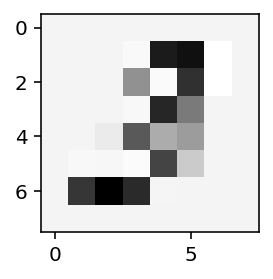

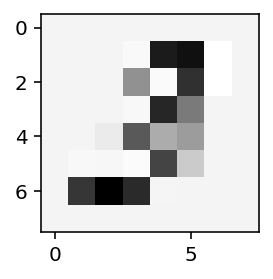

In [24]:
j = 157                       # specific image id
img = phi_train[:,:,j]        # each image is a (1,x) represenattion
show_digit(train_images[j])   # original image
show_digit(img[1,:])          # image asfter the feature map

# Computing the reduced covariance matrix and truncate

In [25]:
def truncate_covariance(a: np.ndarray,
                        eps: Optional[float]=1e-3) -> Tuple[np.ndarray, np.ndarray]:

    """
    Approximate the input covariance matrix by a truncated version.
    Uses the eigendecomposition to diagonaize the input matrix
    and truncates the spectrum p that satisfies the condition
    sum(p)/trace(a) < eps.

    Input:
    ------
    a:      Matrix to be truncated.
    eps:    The truncation error.

    Output:
    -------
    p:      The remaining spectrum.
    U:      The eigenvectors corresponding to p.
    D:      The index of the smallest non-negligible eigenalue.
    """
    assert ishermitian(a), 'Input matrix is not Hermitian.'    
    # the eignevalue decomposition
    p, U = np.linalg.eigh(a)  # p are sorted in ascending order
    # checking the contribution of eignevalues and get the index D
    err = np.cumsum(p / np.trace(a))  # errors see Eq. (19) in text
    idx = np.amin(np.where(err >= np.complex64(eps))[0])  # non-negligible errros
    return p, U, idx

quickly checking

In [26]:
np.random.seed(111)
v = np.random.rand(30,10) + 1j*np.random.rand(30,10)
a = v @ v.conj().T  # covariance matrix

p,U,D = truncate_covariance(a)
assert np.allclose((U[:,D:] * p[D:]) @ U[:,D:].conj().T, a)

In [27]:
def go(a: np.ndarray, eps: Optional[float]=1e-3) -> np.ndarray:
    """
    A single step building a tree layer.

    Input:
    ------
    a:      Array of input data used to construct the isometries.
    eps:    Truncation tolerance.

    Output:
    -------
    A tensor representing the isometries.
    """
    # getting the shape of the input tensor
    u,v,w = a.shape
    # precomputes all density matrices
    rho = np.einsum('ilj,klj->iklj', a, a.conj())
    # initialize the isometries
    isometries  = np.empty(shape=(u**2, u**2, 0), dtype=np.double)
    # initialize the trancation idices for each isometry
    indices = np.empty(shape=(v//2, 0), dtype=int)

    # gets the sliding window iterator
    iterator = sliding_window(np.arange(v), step=2, size=2)
    
    for i,j in iterator:

        if i == 0:
            # an edge case
            left = np.ones(w)
        else:
            # contraction of all parts to the left of the pointer (i.e. l)
            left = np.einsum('ikj,ikj->j', a[:,:i,:], a[:,:i,:].conj())

        if j == v-1:
            # an edge case
            right = np.ones(w)
        else:
            # contraction all parts to the right of the pointer (i.e. r+1)
            right = np.einsum('ikj,ikj->j', a[:,j+1:,:], a[:,j+1:,:].conj())

        # reduced density matrix for the window
        rho_ij = np.einsum('ikj,mnj->imknj', rho[:,:,i,:], rho[:,:,j,:])
        # scaled by left and right parts (aka reduced density matrix)
        rho_ij = np.einsum('...j,...j,...j', left, rho_ij, right)
        
        # eigen decomposition
        _, U, idx = truncate_covariance(rho_ij.reshape(u**2, u**2), eps)

        isometries = np.append(isometries, U[:,:,np.newaxis], axis=2)
        indices = np.append(indices, idx)

    # get a uniform trancation index for ALL isometries (see Eq. 19)
    D = np.min(indices)
    # trancating
    isometries = isometries[:,D:,:].reshape(u, u, -1, v//2)                   
    return isometries

In [28]:
def project(a, iso: np.ndarray, *other: Iterable[np.ndarray]) -> np.ndarray:
    """
    A projector of input tesnor 'a' onto the isometries.
    The tensor is first split into 2 parts corresponding
    to two input legs of the isoemtry tensor (see picture
    below for details).
           out      
            | 
           iso  
           / \ 
    a -> a1   a2

    Input:
    ------
    a:      Tesnor to be projected.
    iso:    Tensor with isometries to be projected on.
    other:  A tail of the iterable containing isometries. 

    Output:
    -------
    A result of the projection.
    """
    # split the array in two parts (correspond to two legs of the input)
    a1, a2 = np.split(a, 2, axis=1)
    # projection of a onto isometries
    out = np.einsum('ilk,jlk,ijml->mlk', a1, a2, iso)
    if other:
        return project(out, *other)
    else:
        return out

In [29]:
def build_tree(a: np.ndarray, eps: Optional[float]=1e-3) -> Iterable[np.ndarray]:
    """
    A tree constructor.

    Input:
    ------
    a:      Array with input data to the tree constructor.
    eps:    Trancation tolerance.

    Output:
    -------
    An iterator spitting the isometries for each tree layer.
    """
    # getting the shape of the input tensor
    u,v,w = a.shape

    assert is_power_of_two(v), 'The number of features must be a power of 2'

    # process until stopping criterium
    if v > 2:
        isometries = go(a, eps=eps)
        yield isometries
        # creating the input for the next step
        a_new = project(a, isometries)
        yield from build_tree(a_new, eps=eps)

In [30]:
tree_iterator = build_tree(phi_train, eps=7e-2)
# reuse the expensive iterator
tree_train, tree_test = itertools.tee(tree_iterator)

All data after coarse graining.

In [31]:
train_labels = data['train']['labels']
test_labels = data['test']['labels']

train_data = project(phi_train, *tree_train)
test_data = project(phi_test, *tree_test)

In [32]:
train_data.shape, test_data.shape

((11, 2, 60000), (11, 2, 10000))

# Classifying digits

Below I want to compare my implementation of CGD to Sklearn Logistic model. Start with Logistic regression.

In [33]:
i,j,n = train_data.shape
k,l,m = test_data.shape

assert i==k and j==l, 'Data shapes mismatch'

X_train = train_data.reshape(i*j,n).T
X_test = test_data.reshape(k*l,m).T

y_train = np.argwhere(train_labels==.99)[:,1]  # need to convert it back as Sklearn require raw labels
y_test = np.argwhere(test_labels==.99)[:,1]    # same here

In [34]:
X_train.shape

(60000, 22)

In [35]:
model = LogisticRegression(multi_class='ovr', solver='newton-cg')  # the CGD classifier is also OvA
model.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='newton-cg')

In [36]:
y_pred = model.predict(X_test)
print(f"Classification report for classifier {model}:\n\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Classification report for classifier LogisticRegression(multi_class='ovr', solver='newton-cg'):

              precision    recall  f1-score   support

           0       0.59      0.66      0.62       980
           1       0.39      0.95      0.56      1135
           2       0.63      0.40      0.49      1032
           3       0.46      0.43      0.44      1010
           4       0.51      0.44      0.47       982
           5       0.43      0.06      0.11       892
           6       0.58      0.51      0.54       958
           7       0.43      0.62      0.51      1028
           8       0.55      0.37      0.44       974
           9       0.59      0.35      0.44      1009

    accuracy                           0.49     10000
   macro avg       0.51      0.48      0.46     10000
weighted avg       0.51      0.49      0.47     10000




In [37]:
print(f'Classification confusion matrix:\n\n'
      f'{metrics.confusion_matrix(y_test, y_pred)}\n')

Classification confusion matrix:

[[ 645   64   27   45   18   31   34  100   15    1]
 [   2 1079    9   14    0    1    2    2   23    3]
 [  66  115  413   82   42    7  142   69   85   11]
 [  42  201   26  432   27   21   23  166   41   31]
 [  27  208   10   42  430    2   43   78   26  116]
 [ 130  321   17  168   33   56   26   83   45   13]
 [ 103   66   50   59  107    5  485   48   27    8]
 [  22  243   19   10   32    1   32  635    5   29]
 [  55  242   77   69   16    4   19  101  356   35]
 [   9  212    8   16  144    1   37  200   28  354]]



In [38]:
# # Plot normalized confusion matrix
# fig, ax = plt.subplots(figsize=(12, 12))
# disp = metrics.plot_confusion_matrix(
#     model, X_test, y_test, 
#     display_labels=np.arange(10),
#     cmap=plt.cm.Blues, 
#     ax=ax,
#     normalize='true')
# disp.ax_.set_title(f'Accuracy (Tree TN Compression): {metrics.accuracy_score(y_test, y_pred)}')
# plt.show()

# Training on the original dataset for reference

Below I want to see how much 'information' is lost after the coarse graining. For this, I train the same logistic regression classifier as above on the full dataset.

In [39]:
X_train = train_images
X_test = test_images

In [40]:
X_train.shape

(60000, 64)

In [41]:
model_orig = LogisticRegression(multi_class='ovr', solver='newton-cg')  # same again, CGD is OvA and I want direct comparison
model_orig.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', solver='newton-cg')

In [42]:
y_pred_orig = model_orig.predict(X_test)
print(f"Classification report for classifier {model}:\n\n"
      f"{metrics.classification_report(y_test, y_pred_orig)}\n")

Classification report for classifier LogisticRegression(multi_class='ovr', solver='newton-cg'):

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       980
           1       0.86      0.94      0.89      1135
           2       0.88      0.81      0.84      1032
           3       0.80      0.79      0.79      1010
           4       0.79      0.79      0.79       982
           5       0.75      0.69      0.72       892
           6       0.84      0.88      0.86       958
           7       0.81      0.84      0.82      1028
           8       0.75      0.76      0.75       974
           9       0.76      0.71      0.73      1009

    accuracy                           0.82     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.82      0.82      0.82     10000




In [43]:
print(f'Classification confusion matrix:\n\n'
      f'{metrics.confusion_matrix(y_test, y_pred_orig)}\n')

Classification confusion matrix:

[[ 918    1    5    4    0   26   15    3    6    2]
 [   0 1062    7    6    2   15    7    0   36    0]
 [  15   34  831   31   19    7   21   12   51   11]
 [   8   27   30  798    7   62    5   25   27   21]
 [   4   18    8    4  777   11   29   20   28   83]
 [  14   12   11   81   25  619   43   10   48   29]
 [  12    7   14    6   22   29  847    4   14    3]
 [   4   37   23    5   22    4    2  860    5   66]
 [  14   27   15   56   19   40   24   24  738   17]
 [  10   17    4   12   96   13   10  100   28  719]]



# My conjugate gradient method implementation

I want to follow the paper as close as possible (and also learn something along the line). So, I have decided to implement a custom conjugate gradient descent algorithm that the paper is using as well.

In [44]:
def conjugate_gradient(A, b, tol=1e-6):
    x = np.ones_like(b)
    r = A @ x - b
    d = -r
    while True:
        r2 = r @ r
        if np.sqrt(r2) < tol:
            break
        Ad = A @ d
        alpha = r2 / (d @ Ad)
        x = x + alpha * d
        r = r + alpha * Ad
        beta = r @ r / r2
        d = -r + beta * d
    return x

Testing it on a randomly generated dataset.

In [45]:
n = 1000

np.random.seed(0)
A = np.random.normal(size=(n,n))
A = A.T @ A

# below are the requirements of the CGD algorithm.
assert ispsd(A), 'The matrix is not PSD'
assert ishermitian, 'The matrix is not Hermitian'    

b = np.random.rand(n)
%time x = conjugate_gradient(A, b)
np.allclose(A @ x, b, atol=1e-5)

CPU times: user 701 ms, sys: 42 ms, total: 743 ms
Wall time: 92.9 ms


True

# Train a classifier for each digit separately using CGD

In [46]:
i,j,n = train_data.shape
k,l,m = test_data.shape

assert i==k and j==l, 'Data shapes mismatch'

X_train = train_data.reshape(i*j,n).T
X_test = test_data.reshape(k*l,m).T

y_train = np.argwhere(train_labels==.99)[:,1]
y_test = np.argwhere(test_labels==.99)[:,1]

In [47]:
def clf_build(X, y):
    """
    Train a OvA classifier.
    """
    # getting the shape
    m,n = X.shape

    # assumed number of digits in the dataset
    n_digits = 10
    
    # storing weights
    W = np.zeros(shape=(n_digits,n+1), dtype=np.double)
    
    # adding bias term
    X_ = np.ones(shape=(m,n+1), dtype=np.double)
    X_[:,1:] = X

    # optimize the weights for each digit
    for digit in np.arange(n_digits):
        y_ = np.where(y != digit, 0.01, 0.99)
        # train cgd with square loss
        Z = X_.T @ X_
        q = X_.T @ y_
        W[digit,:] = conjugate_gradient(Z,q)
    # returns a set of parameters n_classes x n_features
    return W

def clf_predict(W, X):
    # resizing the arrray if one sample provided
    if X.ndim == 1:
        X = X[np.newaxis,:]
    # getting the shape
    m,n = X.shape
    # assumed number of digits in the dataset
    n_digits = 10
    # adding bias term
    X_ = np.ones(shape=(m,n+1), dtype=np.double)
    X_[:,1:] = X
    # stores predictions
    y_pred = np.zeros(shape=(m, n_digits), dtype=np.double)
    for digit in np.arange(n_digits):
        y_pred[:,digit] = X_ @ W[digit,:]
    return np.argmax(y_pred, axis=1)

In [48]:
W = clf_build(X_train, y_train)
y_pred = clf_predict(W, X_test)

We can now also check a single sample...

In [49]:
print(f'Classification report for classifier {model}:\n\n'
      f'{metrics.classification_report(y_test, y_pred)}\n')

Classification report for classifier LogisticRegression(multi_class='ovr', solver='newton-cg'):

              precision    recall  f1-score   support

           0       0.58      0.70      0.63       980
           1       0.40      0.97      0.56      1135
           2       0.67      0.42      0.51      1032
           3       0.48      0.46      0.47      1010
           4       0.47      0.61      0.53       982
           5       0.51      0.04      0.08       892
           6       0.53      0.51      0.52       958
           7       0.45      0.54      0.49      1028
           8       0.57      0.37      0.45       974
           9       0.64      0.20      0.30      1009

    accuracy                           0.49     10000
   macro avg       0.53      0.48      0.46     10000
weighted avg       0.53      0.49      0.46     10000




In [50]:
print(f'Classification confusion matrix:\n\n'
      f'{metrics.confusion_matrix(y_test, y_pred)}\n')

Classification confusion matrix:

[[ 683   55   26   26   64   15   26   72    6    7]
 [   2 1104    3    5    0    0    3    1   16    1]
 [  66  135  430   95   64    8  112   54   62    6]
 [  44  179   24  468   31   10   31  167   42   14]
 [  31  158   11   48  595    0   50   34   13   42]
 [ 138  266   14  155  100   38   27   89   55   10]
 [ 116   80   48   67   99    1  486   33   21    7]
 [  30  293   19   19   43    0   61  552    3    8]
 [  53  275   63   68   12    2   29   91  365   16]
 [  12  247    4   28  253    0   84  131   52  198]]



# Sandbox

## Brute force method (easy to understand)

In [51]:
np.random.seed(0)
phi_rand = np.random.rand(3, 196, 1000)

In [52]:
from timeit import default_timer as timer

def exec_time(tic, toc):
   diff_time = toc - tic
   ms = diff_time
   m, s = divmod(diff_time, 60)
   h, m = divmod(m, 60)
   s,m,h = int(round(s, 0)), int(round(m, 0)), int(round(h, 0))
   print('Execution Time: ' + f'{h:02d}:{m:02d}:{s:02d}:{ms:.4f}')

In [53]:
l,r = 8,9
u,v,w = phi_rand.shape

tic = timer()

rho1 = np.zeros([u,u,u,u])
for j in range(w):
    left = np.einsum('ik,ik', phi_rand[:,:l,j], phi_rand[:,:l,j].conj())
    right = np.einsum('ik,ik', phi_rand[:,r+1:,j], phi_rand[:,r+1:,j].conj())

    # i   m
    # |   |
    # +---+
    # |   |
    # +---+
    # |   |
    # k   n

    for i in range(u):
        for k in range(u):
            for m in range(u):
                for n in range(u):
                    rho1[i,k,m,n] += left * right * phi_rand[i,l,j] * phi_rand[m,l,j].conj() * phi_rand[k,r,j] * phi_rand[n,r,j].conj()

toc = timer()
time1 = toc-tic

exec_time(tic,toc)

Execution Time: 00:00:00:0.1829


## Same as above, but using vectorization

In [54]:
tic = timer()

u,v,w = phi_rand.shape

l,r = 8,9

# computes all density matrices for each j
rho2 = np.einsum('ilj,klj->iklj', phi_rand, phi_rand.conj())
# contraction of all parts to the left of the pointer (i.e. l)
left = np.einsum('ikj,ikj->j', phi_rand[:,:l,:], phi_rand[:,:l,:].conj())
# contraction all parts to the right of the pointer (i.e. r+1)
right = np.einsum('ikj,ikj->j', phi_rand[:,r+1:,:], phi_rand[:,r+1:,:].conj())
# reduced density matrix for the window
rho2 = np.einsum('ikj,mnj->imknj', rho2[:,:,l,:], rho2[:,:,r,:])
# scaled by left and right
rho2 = np.einsum('...j,...j,...j', rho2, left, right)

toc = timer()
time2 = toc-tic

exec_time(tic,toc)

Execution Time: 00:00:00:0.0084


## Checking that the results are the same

In [55]:
np.allclose(rho1, rho2)

True

## Time gain

In [56]:
time1 / time2

21.733568237846562